In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn import svm
from builtins import range
from six.moves import cPickle as pickle
import os
import platform

# matplotlib figures可视化在笔记本中
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 12.0) # 设置绘图的默认大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))


def load_CIFAR_batch(filename):
    """ load cifar的一个batch """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

In [3]:
def load_CIFAR10(ROOT):
    """ load cifar的全部 """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte

In [4]:
# 加载原始CIFAR-10数据
cifar10_dir = 'cifar-10-batches-py'

# 清理变量以防止多次加载数据（这可能会导致内存问题）
try:
   del X_train, y_train
   del X_test, y_test
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [5]:
print('Training data shape  : ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape      : ', X_test.shape)
print('Test labels shape    : ', y_test.shape)

Training data shape  :  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape      :  (10000, 32, 32, 3)
Test labels shape    :  (10000,)


In [6]:
def visualize_N_Sample(X_train,y_train,n,classesNames):
    num_classes = len(classesNames)
    samples_per_class = n
    for y, cls in enumerate(classesNames):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    

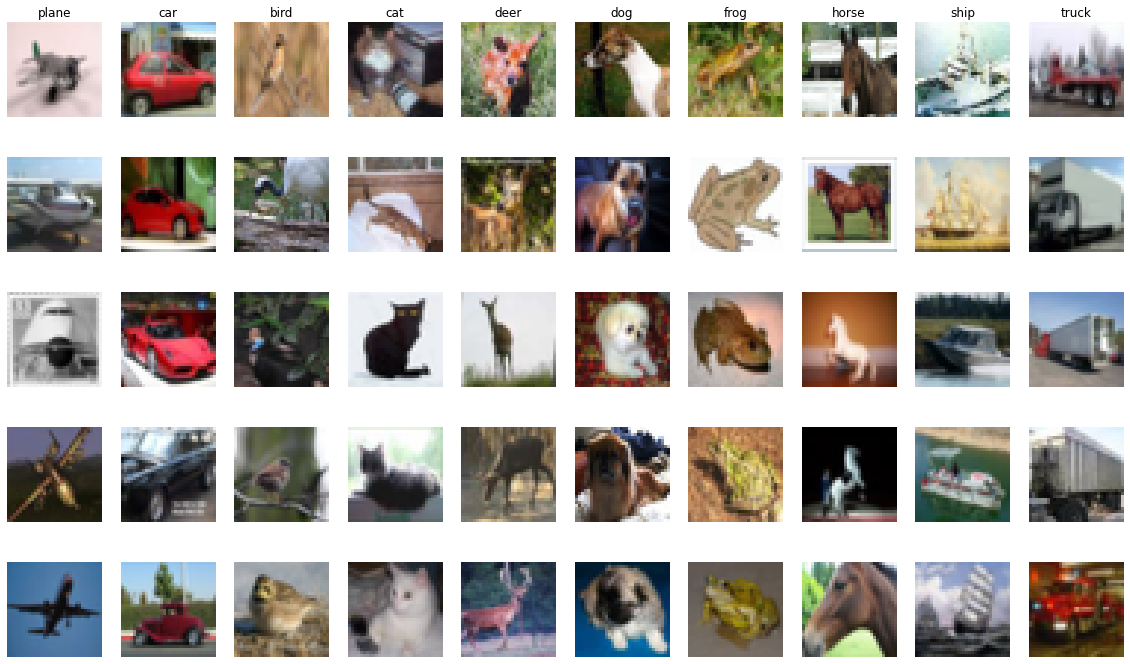

In [7]:
visualize_N_Sample(X_train,y_train,5,['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

In [8]:
# 对数据进行子采样，以便更有效地执行代码
num_training = 50000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [9]:
print('Training data shape  : ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape      : ', X_test.shape)
print('Test labels shape    : ', y_test.shape)

Training data shape  :  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape      :  (1000, 32, 32, 3)
Test labels shape    :  (1000,)


In [10]:
# 将图像数据reshape为rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [11]:
print('Training data shape  : ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape      : ', X_test.shape)
print('Test labels shape    : ', y_test.shape)

Training data shape  :  (50000, 3072)
Training labels shape:  (50000,)
Test data shape      :  (1000, 3072)
Test labels shape    :  (1000,)


In [12]:
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image

In [13]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

In [14]:
scaled_X_train=X_train
scaled_X_test=X_test

In [15]:
from builtins import range
from builtins import object
import numpy as np
import time
import operator

class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        KNN中的训练步骤只是存储训练数据。
        输入：
        -X：形状的numpy数组（num_train，D）
        包含由每个维度为D的num_ train样本组成的训练数据。
        -y：包含训练标签的形状（N，）的numpy数组，其中y[i]是X[i]的标签。
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1,loops=0):

        """
        使用此分类器预测测试数据的标签。
        输入：
        -X：形状（num_test，D）的numpy数组，包含由每个维度为D的num_test样本组成的测试数据。
        -k：投票支持预测标签的最近邻居的数量。
        -num_loops：确定使用哪个实现来计算训练点和测试点之间的距离。
        返回值：
        -y：形状（num_test）的numpy数组，包含测试数据的预测标签，其中y[i]是测试点X[i]的预测标签。
        """
        if loops==0:
            dists = self.compute_distances_no_loops(X)
        else:
            dists = self.compute_distances_one_loop(X)

        return self.predict_labels(dists, k=k)

    def compute_distances_one_loop(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i, :]), axis = 1))
        return dists

    def compute_distances_no_loops(self, X):

        dists = np.sqrt(np.multiply(np.dot(X, self.X_train.T), -2) + np.sum(self.X_train ** 2, axis=1) + np.sum(X ** 2, axis=1)[:, np.newaxis])

        return dists

    def predict_labels(self, dists,k=1):
        """
        给定测试点和训练点之间的距离矩阵，

        预测每个测试点的标签。
        输入：
        -dists：形状（num_test，num_train）的numpy数组，其中dists[i，j]
        给出了第i个测试点和第j个训练点之间的距离。

        返回值：
        -y：形状（num_test）的numpy数组，包含
        测试数据，其中y[i]是测试点X[i]的预测标签。
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        k_nearest_index = np.argsort(dists, axis=1)[:, :k]
        k_nearest_labels = self.y_train[k_nearest_index]

        for i in range(num_test):
            counts = np.bincount(k_nearest_labels[i])
            y_pred[i] = np.argmax(counts)
            
        return y_pred

In [16]:
from sklearn.metrics import accuracy_score

k_choices = [5,13,19,21,23,25,27,29,31,101]
k_accuracies = []
clf = KNearestNeighbor()
clf.train(scaled_X_train, y_train)

for k in k_choices:
    y_test_pred = clf.predict(scaled_X_test,k,0)
    acc= accuracy_score(y_test, y_test_pred)*100
    k_accuracies.append(acc)

In [17]:
from sklearn.metrics import accuracy_score

k_choices = [5,13,19,21,23,25,27,29,31,101]
k_accuracies = []
clf = KNearestNeighbor()
clf.train(scaled_X_train, y_train)

for k in k_choices:
    y_test_pred = clf.predict(scaled_X_test,k,0)
    acc= accuracy_score(y_test, y_test_pred)*100
    k_accuracies.append(acc)

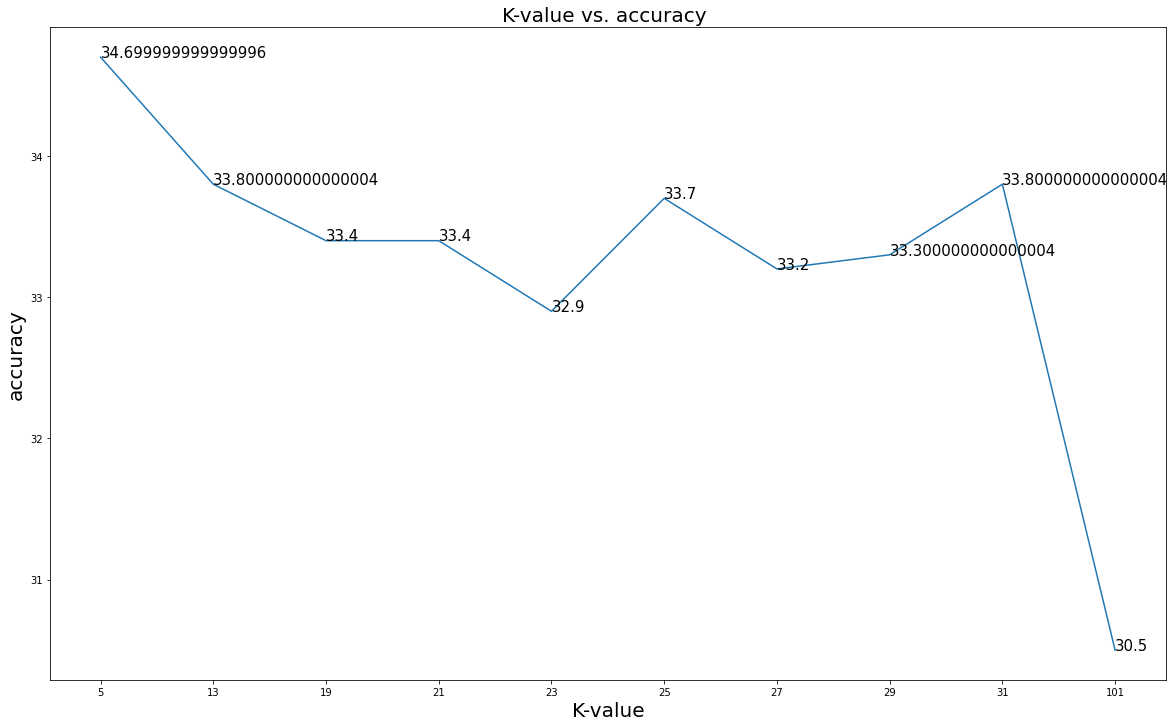

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
k_choices_str = ['5','13','19','21','23','25','27','29','31','101']
ax.plot(k_choices_str,k_accuracies)

ax.set_xlabel("K-value",fontsize=20)
ax.set_ylabel("accuracy",fontsize=20)

ax.set_title("K-value vs. accuracy ",fontsize=20)

for i in range(len(k_choices_str)):
    plt.annotate(str(k_accuracies[i]), xy=(k_choices_str[i], k_accuracies[i]),fontsize=15)
    
plt.show()

In [19]:
knn_clf = KNearestNeighbor()

knn_clf.train(scaled_X_train, y_train)

y_test_pred = knn_clf.predict(X=scaled_X_test,k=5,loops=0)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print(f"The model handle {num_correct} correctly out of {num_test}, its Accuracy:{accuracy*100:.2f}%")

The model handle 347 correctly out of 1000, its Accuracy:34.70%


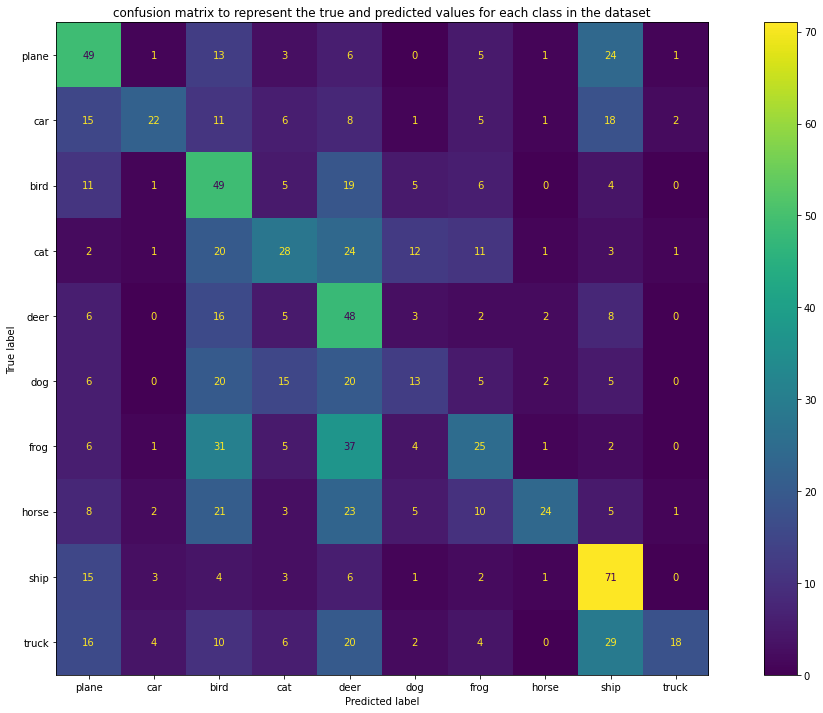

In [20]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
disp.plot()
plt.title("confusion matrix to represent the true and predicted values for each class in the dataset")
plt.show()

In [21]:
y_train2 = y_train.copy()
y_test2 = y_test.copy()
check_set = y_test.copy()

In [22]:
y_train

array([6, 9, 9, ..., 9, 1, 1])

In [23]:
# 获取二进制标签（OvR）
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train2 = mlb.fit_transform(y_train2.reshape((-1,1)))
y_test2 = mlb.fit_transform(y_test2.reshape((-1,1)))

In [24]:
y_train2

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [25]:
# for training
y1 = y_train2[:,0]
y2 = y_train2[:,1]
y3 = y_train2[:,2]
y4 = y_train2[:,3]
y5 = y_train2[:,4]
y6 = y_train2[:,5]
y7 = y_train2[:,6]
y8 = y_train2[:,7]
y9 = y_train2[:,8]
y10 = y_train2[:,9]


# for testing
yT1 = y_test2[:,0]
yT2 = y_test2[:,1]
yT3 = y_test2[:,2]
yT4 = y_test2[:,3]
yT5 = y_test2[:,4]
yT6 = y_test2[:,5]
yT7 = y_test2[:,6]
yT8 = y_test2[:,7]
yT9 = y_test2[:,8]
yT10 = y_test2[:,9]

In [26]:
class LogisticReressionClassifier:
    def __init__(self, max_iter=200, learning_rate=0.02):
        self.max_iter = max_iter
        self.learning_rate = learning_rate

    # sigmoid激活函数
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))


    def data_matrix(self, X):
        data_mat = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        return data_mat

    def fit(self, X, y):
        # label = np.mat(y)
        data_mat = self.data_matrix(X) # m*n
        self.weights = np.zeros((len(data_mat[0]),1), dtype=np.float32)

        for iter_ in range(self.max_iter):
            results = self.sigmoid(np.dot(data_mat, self.weights))
            errors = y.reshape(len(y),1) - results
            self.weights += self.learning_rate * np.dot(np.transpose(data_mat), errors)
        print('LogisticRegression Model(learning_rate={},max_iter={})'.format(self.learning_rate, self.max_iter))

    def score(self, X_test, y_test):
        X_test = self.data_matrix(X_test)
        results = np.dot(X_test, self.weights)
        rights = ((results > 0) & (y_test == 1)) | ((results < 0) & (y_test == 0))
        accuracy = np.sum(rights) / len(X_test)
        return accuracy

    def predict(self,X_test):
        X_test=self.data_matrix(X_test)
        results=np.matmul(X_test,self.weights)
        result_bool=results>0
        return result_bool.astype(int)

    def predict_proba(self,X_test):
        X_test=self.data_matrix(X_test)
        results=np.matmul(X_test,self.weights)
        return 1/(1+np.exp(-results))

In [27]:
from sklearn.linear_model import LogisticRegression

def manual_OVR(X_train,y_train,X_test,y_test):
    """
    用于制作OVR模型
    Input  : X_train,y_train,X_test,y_test
    Output : returns 返回每个模型的概率(y_pred)和模型本身(oVoClf)
    """

    Clf = LogisticReressionClassifier(learning_rate=1e-11)
    Clf.fit(X_train, y_train)
    
    # get prediction 
    predicted_labes = Clf.predict(X_test)
    
    # get predicted classification probabilities 
    y_pred = Clf.predict_proba(X_test).reshape(-1,1)
    
    return y_pred 

In [28]:
# build models
y1_pred = manual_OVR(scaled_X_train,y1,scaled_X_test,yT1)
y2_pred = manual_OVR(scaled_X_train,y2,scaled_X_test,yT2)
y3_pred = manual_OVR(scaled_X_train,y3,scaled_X_test,yT3)
y4_pred = manual_OVR(scaled_X_train,y4,scaled_X_test,yT4)
y5_pred = manual_OVR(scaled_X_train,y5,scaled_X_test,yT5)
y6_pred = manual_OVR(scaled_X_train,y6,scaled_X_test,yT6)
y7_pred = manual_OVR(scaled_X_train,y7,scaled_X_test,yT7)
y8_pred = manual_OVR(scaled_X_train,y8,scaled_X_test,yT8)
y9_pred = manual_OVR(scaled_X_train,y9,scaled_X_test,yT9)
y10_pred = manual_OVR(scaled_X_train,y10,scaled_X_test,yT10)

LogisticRegression Model(learning_rate=1e-11,max_iter=200)
LogisticRegression Model(learning_rate=1e-11,max_iter=200)
LogisticRegression Model(learning_rate=1e-11,max_iter=200)
LogisticRegression Model(learning_rate=1e-11,max_iter=200)
LogisticRegression Model(learning_rate=1e-11,max_iter=200)
LogisticRegression Model(learning_rate=1e-11,max_iter=200)
LogisticRegression Model(learning_rate=1e-11,max_iter=200)
LogisticRegression Model(learning_rate=1e-11,max_iter=200)
LogisticRegression Model(learning_rate=1e-11,max_iter=200)
LogisticRegression Model(learning_rate=1e-11,max_iter=200)


In [29]:
# 将10个模型的所有预测结果组合起来
y_all = np.hstack((y1_pred, y2_pred, y3_pred,y4_pred,y5_pred,y6_pred,y7_pred,y8_pred,y9_pred,y10_pred))

#使用argmax聚合置信度得分，获得最终预测标签并获得performance
m1 = mlb.classes_[np.argmax(y_all, axis=1)]

In [30]:
# # 制作混淆矩阵
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(list(check_set),list(m1))


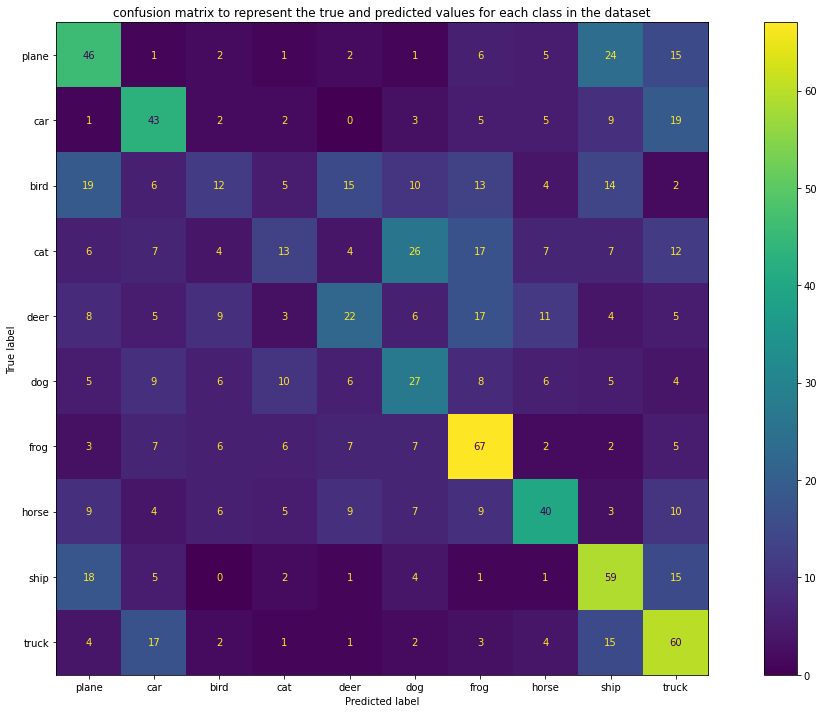

In [31]:
# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
disp.plot()
plt.title("confusion matrix to represent the true and predicted values for each class in the dataset")
plt.show()

In [32]:
from sklearn.metrics import accuracy_score
accuracy_score(list(check_set), list(m1))*100

38.9

In [33]:
class LinearSVM:
    def __init__(self):
        self.W = None
    
    def loss(self, X, y, reg):
        """
        结构化SVM损失函数，矢量化实现。
        输入和输出与svm_loss_naive相同。
        """
        loss = 0.0
        dW = np.zeros(self.W.shape)

        num_train = X.shape[0]
        scores = X.dot(self.W)
        correct_class_score = scores[range(num_train), list(y)].reshape(-1,1) # (N,1)
        margin = np.maximum(0, scores - correct_class_score + 1)
        margin[range(num_train), list(y)] = 0
        loss = np.sum(margin) / num_train + 0.5 * reg * np.sum(self.W * self.W)
  
        num_classes = self.W.shape[1]
        inter_mat = np.zeros((num_train, num_classes))
        inter_mat[margin > 0] = 1
        inter_mat[range(num_train), list(y)] = 0
        inter_mat[range(num_train), list(y)] = -np.sum(inter_mat, axis=1)

        dW = (X.T).dot(inter_mat)
        dW = dW/num_train + reg*self.W

        return loss, dW
    
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
        """
        使用随机梯度下降训练这个线性分类器。

        输入：
        -X：包含训练数据的形状（N，D）的numpy数组；有N个
        训练每个维度D的样本。
        -y：包含训练标签的形状（N，）的numpy数组；y[i]=c
        意味着X[i]对于c类具有标签0<=c<c。
        -learning_rate：用于优化的（浮动）学习速率。
        -reg:（浮点）正则化强度。
        -num_iters：（整数）优化时要执行的步骤数
        -batch_size：在每个步骤中使用的训练示例的数量（整数）。
        -verbose：（boolean）如果为true，则在优化期间打印进度。

        输出：
        一个列表，包含每次训练迭代时损失函数的值。
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, num_classes)

        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None
            idx_batch = np.random.choice(num_train, batch_size, replace = True)
            X_batch = X[idx_batch]
            y_batch = y[idx_batch]

            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            self.W -=  learning_rate * grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history
    
    def predict(self, X):
        """
        使用此线性分类器的训练权重来预测数据点。

        输入：
        -X：包含训练数据的形状（N，D）的numpy数组；有N个训练每个维度D的样本。

        返回值：
        -y_pred：X中数据的预测标签。y_pred是一维的长度为N的数组，每个元素都是一个整数
        """
        y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis = 1)
        return y_pred

iteration 0 / 1500: loss 407.927961
iteration 100 / 1500: loss 242.877125
iteration 200 / 1500: loss 148.614740
iteration 300 / 1500: loss 91.772727
iteration 400 / 1500: loss 56.773967
iteration 500 / 1500: loss 36.579365
iteration 600 / 1500: loss 23.524894
iteration 700 / 1500: loss 15.736892
iteration 800 / 1500: loss 11.749884
iteration 900 / 1500: loss 9.511874
iteration 1000 / 1500: loss 7.392622
iteration 1100 / 1500: loss 6.367272
iteration 1200 / 1500: loss 6.030322
iteration 1300 / 1500: loss 6.325914
iteration 1400 / 1500: loss 5.146668
That took 4.869042s


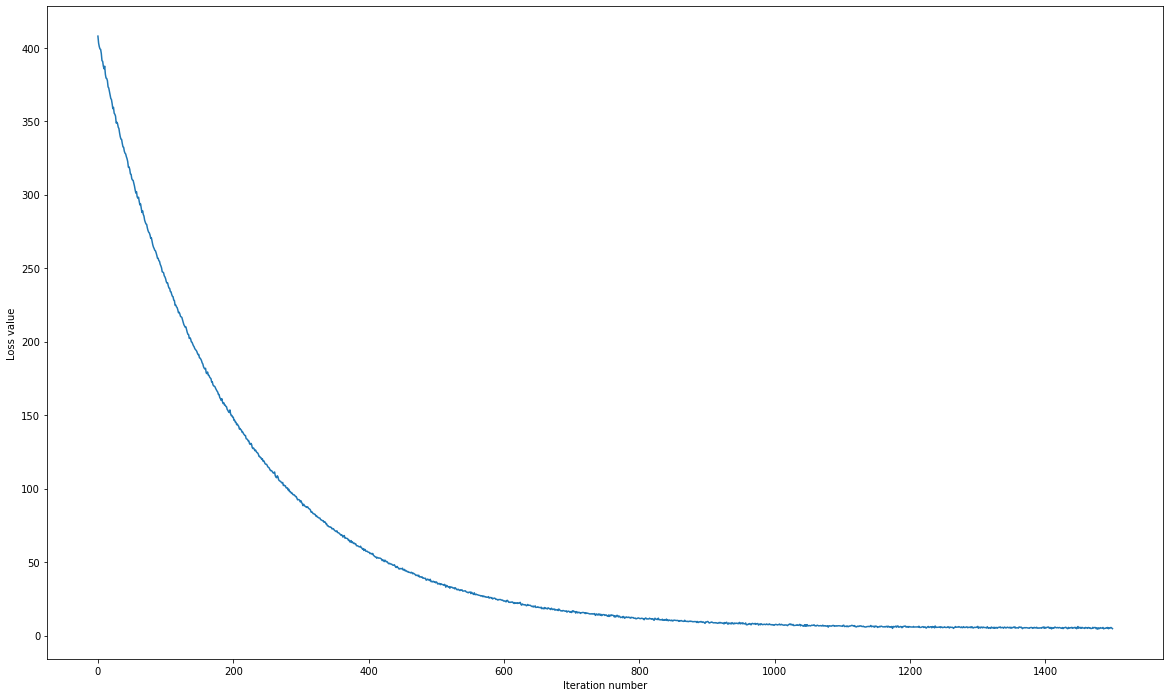

In [35]:
import time
svm2 = LinearSVM()
tic = time.time()
loss_hist = svm2.train(scaled_X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [36]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and test set
y_train_pred = svm2.predict(scaled_X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = svm2.predict(scaled_X_test)
print('test accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.376540
test accuracy: 0.371000
